In [16]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import HbXConcentrations as hbx
import json

In [17]:
# Load sample Phantom experiments

# Attenuation maps
reconPhantom1 = np.loadtxt("Phantom_ch1_Mean.dat")
reconPhantom2 = np.loadtxt("Phantom_ch3_Mean.dat")

shapeReconPhantom1 = np.shape(reconPhantom1)
shapeReconPhantom2 = np.shape(reconPhantom2)

# Reconstruction data
with open("Phantom_ch1_reconData.json") as json_file:
    reconData = json.load(json_file)

# Center positions and shape
centersShape = reconData['centersShape']
centersPos = np.fromfile("Phantom_ch1_centers.bin", dtype=np.int16).reshape(centersShape)

In [19]:
imRaw = np.zeros((np.shape(reconPhantom1)[0], np.shape(reconPhantom1)[1], 2))
imRaw[:,:,0] = reconPhantom1
imRaw[:,:,1] = reconPhantom2

lambdas = [660, 785, 830]

cropSize = 250

HbXMaps_2D = hbx.MamoRef_dHbX(imRaw, lambdas, centersPos, cropSize, cropSize)
    
desOxyMap_Phantom_2D = HbXMaps_2D[:,:,1]
OxyMap_Phantom_2D = HbXMaps_2D[:,:,0]
TotMap_Phantom_2D = desOxyMap_Phantom_2D + OxyMap_Phantom_2D

Step 1/2...


100%|██████████| 250/250 [00:39<00:00,  6.41it/s]


Step 2/2...


100%|██████████| 70/70 [04:49<00:00,  4.14s/it]


In [25]:
# Flip to match real positions

desOxyMap_Phantom_2D = np.flip(desOxyMap_Phantom_2D, axis=1)
OxyMap_Phantom_2D = np.flip(OxyMap_Phantom_2D, axis=1)
TotMap_Phantom_2D = np.flip(TotMap_Phantom_2D, axis=1)


#desOxyMap_2D_filtered = ndimage.median_filter(desOxyMap_2D,0)
#OxyMap_2D_filtered = ndimage.median_filter(OxyMap_2D,0)

desOxyMap_2D_Phantom_filtered = desOxyMap_Phantom_2D
OxyMap_2D_Phantom_filtered = OxyMap_Phantom_2D

desOxyMap_2D_Phantom_filtered[desOxyMap_2D_Phantom_filtered==np.nan] = 0
OxyMap_2D_Phantom_filtered[OxyMap_2D_Phantom_filtered==np.nan] = 0

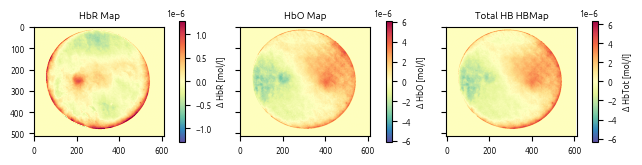

In [26]:
colorMap = "Spectral_r"
    
font = {'family' : 'ubuntu',
        'weight' : 'regular',
        'size'   : 6}

mp.rc('font', **font)



figSats, ((DesOxy, Oxy, Tot)) = plt.subplots(1, 3, sharex=True, sharey=True)

maxDev = 5   

sd = np.nanstd(desOxyMap_2D_Phantom_filtered)
median = np.nanmedian(desOxyMap_2D_Phantom_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd

figDesOxy = DesOxy.imshow(desOxyMap_2D_Phantom_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap])
c1 = figSats.colorbar(figDesOxy, ax=DesOxy, fraction=0.04, pad=0.1)
c1.set_label("Δ HbR [mol/l]")

sd = np.nanstd(OxyMap_2D_Phantom_filtered)
median = np.nanmedian(OxyMap_2D_Phantom_filtered)
vmax = median + maxDev * sd
vmin = median - maxDev * sd


figOxy = Oxy.imshow(OxyMap_2D_Phantom_filtered, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap])
c2 = figSats.colorbar(figOxy, ax=Oxy, fraction=0.04, pad=0.1)
c2.set_label("Δ HbO [mol/l]")


TotMap_Phantom_2D = desOxyMap_2D_Phantom_filtered + OxyMap_2D_Phantom_filtered

sd = np.nanstd(TotMap_Phantom_2D)
median = np.nanmedian(TotMap_Phantom_2D)
vmax = median + maxDev * sd
vmin = median - maxDev * sd


figTot = Tot.imshow(TotMap_Phantom_2D, vmin=vmin, vmax=vmax, cmap=mp.colormaps[colorMap])
c3 = figSats.colorbar(figTot, ax=Tot, fraction=0.04, pad=0.1)
c3.set_label("Δ HbTot [mol/l]")


DesOxy.set_title("HbR Map")

Oxy.set_title("HbO Map")

Tot.set_title("Total HB HBMap")


figSats.tight_layout()

figSats.savefig("PhantomIncs_HbXMaps.png", dpi=300)